In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from filenames import file_name_groups


In [105]:
server_ip_to_filename = {}

def insert_server_ip_filename(is_vpn, server_ip, filename):
    if server_ip not in server_ip_to_filename:
        server_ip_to_filename[server_ip] = {"vpn": [], "nvpn": []}
    server_ip_to_filename[server_ip][is_vpn].append(filename)

def load_csv_file_group(group_idx):
    global server_ip_to_filename
    dfs = []
    server_ip_to_filename = {}
    file_name_group = file_name_groups[group_idx]
    for filename, is_vpn in file_name_group:
        filename = filename.split(".")[0]
        try:
            df = pd.read_csv(f".data/{is_vpn}_csv/{filename}.csv")
            df_len = len(df)
            df['source'] = filename
            df['weight'] = 1 / df_len
            src_series = df['src IP']
            dst_series = df['dst IP']
            series = pd.concat([src_series, dst_series])
            server_IP = series.value_counts().idxmax()
            max_freq = series.value_counts().max()
            if len(src_series) != max_freq:
                print(idx, filename, len(src_series), max_freq)
                continue
            insert_server_ip_filename(is_vpn, server_IP, filename)
            df = df[df['src IP'] != server_IP]
            dfs.append(df)

        except:
            print(filename + ".csv")
            pass


    for server_ip, value in server_ip_to_filename.items():
        print(server_ip, value)

    df = pd.concat(dfs)
    df['src freq'] = df.groupby('src IP')['src IP'].transform('count') * df['weight']
    df['log_freq'] = np.log(df['src freq'])
    df['log_length'] = np.log(df['length'])

    dst_count = df['dst IP'].value_counts()

    return df, server_ip_to_filename

def load_nfs_file_group(group_idx):
    global server_ip_to_filename
    dfs = []
    file_name_group = file_name_groups[group_idx]
    for filename, is_vpn in file_name_group:
        filename = filename.split(".")[0]
        try:
            df = pd.read_csv(f"./preprocessed/nfs/{filename}.csv")
        except:
            print(filename + ".csv")
            pass
        df['log_freq'] = np.log(df['src_freq'])
        dfs.append(df)
    df = pd.concat(dfs)

    return df

0.9955686853766617


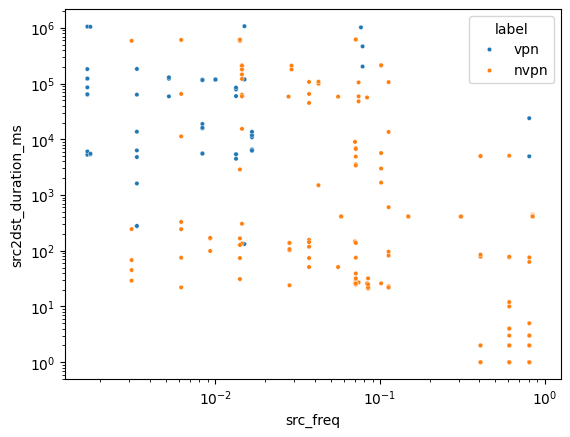

In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from nf_attributes import train_attributes


df = load_nfs_file_group(-1)
file_names = [file_name[0] for file_name in file_name_groups[3]]
df = df[df['file_name'].isin(file_names)]

sns.scatterplot(data=df, x='src_freq', y='src2dst_duration_ms', hue='label', s=10.0, alpha=1.0)
plt.xscale('log')
plt.yscale('log')



X = df[train_attributes]
y = df["label"].apply(lambda x: 1 if x == 'vpn' else 0)
dataset_size = len(X)
train_mask = np.random.rand(dataset_size) < 0.7
X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[~train_mask]
y_test = y[~train_mask]
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print(f1_score(y_test, prediction))

